# Make necessary imports 

In [1]:
# Make necessary imports 

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from collections import Counter
import numpy as np
from scipy.stats import randint

# Train Data

In [2]:

# Path to your CSV file
file_path = r"GUIDE_Train[1].csv"

# Target row count per class
target_rows_per_class = 500_000

# Initialize dictionaries to store sampled data for each class
samples_per_class = {'BenignPositive': [], 'TruePositive': [], 'FalsePositive': []}

# Define chunk size to avoid memory overload
chunk_size = 100_000

# Read the CSV file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # For each class, sample rows if the target has not been reached
    for class_value in samples_per_class.keys():
        # Filter rows of the current class
        class_rows = chunk[chunk['IncidentGrade'] == class_value]

        
        # Calculate how many more rows are needed for this class
        remaining_rows = target_rows_per_class - sum(len(df) for df in samples_per_class[class_value])
        
        # If more rows are needed, sample accordingly
        if remaining_rows > 0:
            samples_per_class[class_value].append(class_rows.sample(n=min(remaining_rows, len(class_rows))))

    # Stop reading further chunks if we’ve collected enough rows for each class
    if all(sum(len(df) for df in samples) >= target_rows_per_class for samples in samples_per_class.values()):
        break

# Concatenate samples to create the final balanced dataset
train_data = pd.concat([pd.concat(samples) for samples in samples_per_class.values()])


C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1160255176.py:19: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1160255176.py:19: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1160255176.py:19: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1160255176.py:19: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1160255176.py:19: DtypeWarning

In [3]:
train_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
18179,1090921695549,48,452814,594116,2024-06-15T04:51:23.000Z,5,72,SuspiciousActivity,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
72477,1503238557882,286,182082,1394350,2024-06-10T18:07:01.000Z,9,74,Execution,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
35692,730144441487,16,110435,290257,2024-06-07T13:21:04.000Z,24,42020,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
29155,1563368099283,247,40087,41875,2024-06-03T13:22:33.000Z,521,566,InitialAccess,T1566;T1193;T1566.001,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
3375,1477468749824,25,1246,7803,2024-06-07T00:02:13.000Z,30,4437,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386475,489626275841,353,164028,827269,2024-06-12T14:53:29.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2318253,738734378854,195,16656,1179035,2024-06-06T17:48:36.000Z,14,12,CredentialAccess,T1110;T1110.003;T1110.001,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2379177,472446407144,9,379,633935,2024-06-13T00:44:23.000Z,31,229,Malware,NaN,FalsePositive,...,NaN,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630
2365397,584115555313,210,2552,6529,2024-06-06T18:47:48.000Z,91,68,CredentialAccess,T1110;T1110.001;T1110.003,FalsePositive,...,NaN,Contextual,5,66,NaN,NaN,NaN,242,1445,10630


# Null check

In [4]:
 train_data.isnull().sum() / len(train_data) * 100

Id                     0.000000
OrgId                  0.000000
IncidentId             0.000000
AlertId                0.000000
Timestamp              0.000000
DetectorId             0.000000
AlertTitle             0.000000
Category               0.000000
MitreTechniques       55.846133
IncidentGrade          0.000000
ActionGrouped         99.945933
ActionGranular        99.945933
EntityType             0.000000
EvidenceRole           0.000000
DeviceId               0.000000
Sha256                 0.000000
IpAddress              0.000000
Url                    0.000000
AccountSid             0.000000
AccountUpn             0.000000
AccountObjectId        0.000000
AccountName            0.000000
DeviceName             0.000000
NetworkMessageId       0.000000
EmailClusterId        99.008067
RegistryKey            0.000000
RegistryValueName      0.000000
RegistryValueData      0.000000
ApplicationId          0.000000
ApplicationName        0.000000
OAuthApplicationId     0.000000
ThreatFa

In [5]:
train_data

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
18179,1090921695549,48,452814,594116,2024-06-15T04:51:23.000Z,5,72,SuspiciousActivity,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
72477,1503238557882,286,182082,1394350,2024-06-10T18:07:01.000Z,9,74,Execution,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
35692,730144441487,16,110435,290257,2024-06-07T13:21:04.000Z,24,42020,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
29155,1563368099283,247,40087,41875,2024-06-03T13:22:33.000Z,521,566,InitialAccess,T1566;T1193;T1566.001,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
3375,1477468749824,25,1246,7803,2024-06-07T00:02:13.000Z,30,4437,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386475,489626275841,353,164028,827269,2024-06-12T14:53:29.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2318253,738734378854,195,16656,1179035,2024-06-06T17:48:36.000Z,14,12,CredentialAccess,T1110;T1110.003;T1110.001,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2379177,472446407144,9,379,633935,2024-06-13T00:44:23.000Z,31,229,Malware,NaN,FalsePositive,...,NaN,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630
2365397,584115555313,210,2552,6529,2024-06-06T18:47:48.000Z,91,68,CredentialAccess,T1110;T1110.001;T1110.003,FalsePositive,...,NaN,Contextual,5,66,NaN,NaN,NaN,242,1445,10630


# Remove duplicate


In [6]:
print(train_data.duplicated().sum())
train_data.drop_duplicates(inplace=True)
print(train_data.duplicated().sum())

803
0


# Drop Column

In [7]:
df=train_data.drop(columns=['MitreTechniques', 'ActionGrouped', 'ActionGranular', 
                      'EmailClusterId', 'ThreatFamily', 'ResourceType', 
                      'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict'])

In [8]:
df


,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
18179,1090921695549,48,452814,594116,2024-06-15T04:51:23.000Z,5,72,SuspiciousActivity,BenignPositive,User,...,3421,881,289573,117668,3586,5,66,242,1445,10630
72477,1503238557882,286,182082,1394350,2024-06-10T18:07:01.000Z,9,74,Execution,BenignPositive,CloudApplication,...,3,881,289573,117668,3586,5,66,242,1445,10630
35692,730144441487,16,110435,290257,2024-06-07T13:21:04.000Z,24,42020,Exfiltration,BenignPositive,User,...,3421,881,289573,117668,3586,5,66,242,1445,10630
29155,1563368099283,247,40087,41875,2024-06-03T13:22:33.000Z,521,566,InitialAccess,BenignPositive,MailMessage,...,3421,881,289573,117668,3586,5,66,242,1445,10630
3375,1477468749824,25,1246,7803,2024-06-07T00:02:13.000Z,30,4437,Exfiltration,BenignPositive,MailMessage,...,3421,881,289573,117668,3586,5,66,242,1445,10630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386475,489626275841,353,164028,827269,2024-06-12T14:53:29.000Z,0,0,InitialAccess,FalsePositive,CloudLogonSession,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2318253,738734378854,195,16656,1179035,2024-06-06T17:48:36.000Z,14,12,CredentialAccess,FalsePositive,CloudLogonRequest,...,3421,881,289573,117668,3586,5,66,242,1445,10630
2379177,472446407144,9,379,633935,2024-06-13T00:44:23.000Z,31,229,Malware,FalsePositive,Machine,...,3421,881,289573,117668,3586,0,0,242,1445,10630
2365397,584115555313,210,2552,6529,2024-06-06T18:47:48.000Z,91,68,CredentialAccess,FalsePositive,User,...,3421,881,289573,117668,3586,5,66,242,1445,10630


In [9]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1499197 entries, 18179 to 2310097
Data columns (total 35 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   Id                  1499197 non-null  int64 
 1   OrgId               1499197 non-null  int64 
 2   IncidentId          1499197 non-null  int64 
 3   AlertId             1499197 non-null  int64 
 4   Timestamp           1499197 non-null  object
 5   DetectorId          1499197 non-null  int64 
 6   AlertTitle          1499197 non-null  int64 
 7   Category            1499197 non-null  object
 8   IncidentGrade       1499197 non-null  object
 9   EntityType          1499197 non-null  object
 10  EvidenceRole        1499197 non-null  object
 11  DeviceId            1499197 non-null  int64 
 12  Sha256              1499197 non-null  int64 
 13  IpAddress           1499197 non-null  int64 
 14  Url                 1499197 non-null  int64 
 15  AccountSid          1499197 non-n

In [10]:

df.isna().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [11]:
pd.DataFrame(df['Timestamp'])

,Timestamp
18179,2024-06-15T04:51:23.000Z
72477,2024-06-10T18:07:01.000Z
35692,2024-06-07T13:21:04.000Z
29155,2024-06-03T13:22:33.000Z
3375,2024-06-07T00:02:13.000Z
...,...
2386475,2024-06-12T14:53:29.000Z
2318253,2024-06-06T17:48:36.000Z
2379177,2024-06-13T00:44:23.000Z
2365397,2024-06-06T18:47:48.000Z


#  Feature engineering 
 

In [12]:
# Convert 'Timestamp' column to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Extract day, month, hour, and week from the 'Timestamp' column
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

# Use isocalendar() to extract the week number
df['Week'] = df['Timestamp'].dt.isocalendar().week

# Drop the 'Timestamp' column as it's no longer needed
df.drop(columns=['Timestamp'], inplace=True)


In [13]:
df['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    499999
FalsePositive     499856
TruePositive      499342
Name: count, dtype: int64

In [14]:
df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Hour,Week
18179,1090921695549,48,452814,594116,5,72,SuspiciousActivity,BenignPositive,User,Impacted,...,3586,5,66,242,1445,10630,15,6,4,24
72477,1503238557882,286,182082,1394350,9,74,Execution,BenignPositive,CloudApplication,Impacted,...,3586,5,66,242,1445,10630,10,6,18,24
35692,730144441487,16,110435,290257,24,42020,Exfiltration,BenignPositive,User,Impacted,...,3586,5,66,242,1445,10630,7,6,13,23
29155,1563368099283,247,40087,41875,521,566,InitialAccess,BenignPositive,MailMessage,Related,...,3586,5,66,242,1445,10630,3,6,13,23
3375,1477468749824,25,1246,7803,30,4437,Exfiltration,BenignPositive,MailMessage,Impacted,...,3586,5,66,242,1445,10630,7,6,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386475,489626275841,353,164028,827269,0,0,InitialAccess,FalsePositive,CloudLogonSession,Related,...,3586,5,66,242,1445,10630,12,6,14,24
2318253,738734378854,195,16656,1179035,14,12,CredentialAccess,FalsePositive,CloudLogonRequest,Related,...,3586,5,66,242,1445,10630,6,6,17,23
2379177,472446407144,9,379,633935,31,229,Malware,FalsePositive,Machine,Impacted,...,3586,0,0,242,1445,10630,13,6,0,24
2365397,584115555313,210,2552,6529,91,68,CredentialAccess,FalsePositive,User,Related,...,3586,5,66,242,1445,10630,6,6,18,23


# IncidentGrade Counts Across Categories Plot

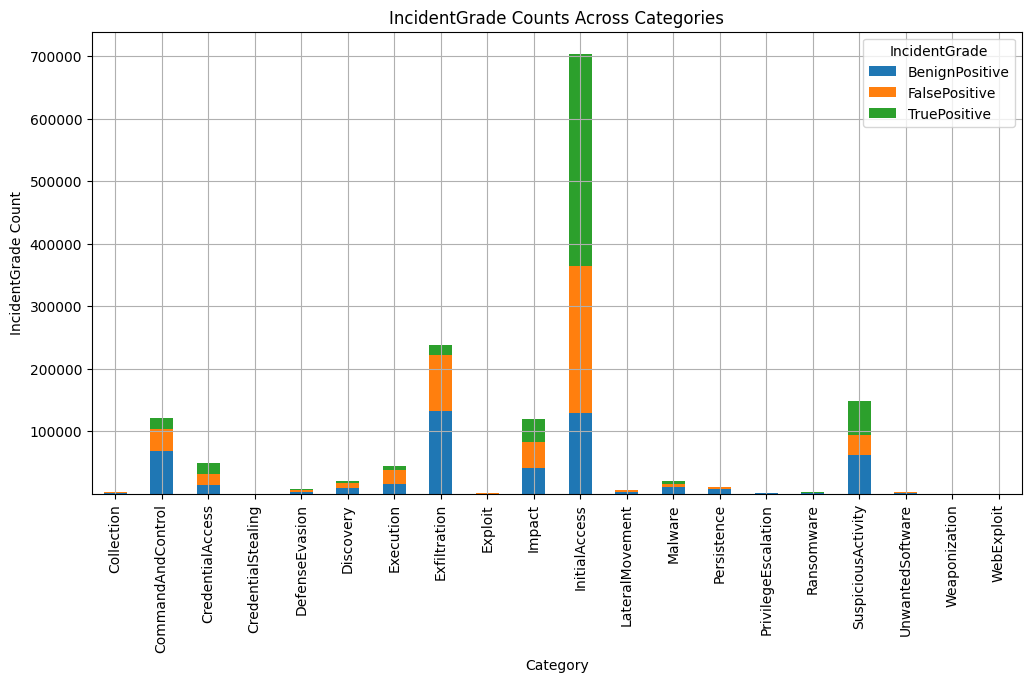

In [15]:
category_incidentgrade_counts = df.groupby(['Category', 'IncidentGrade']).size().unstack()

# Plot the bar plot
category_incidentgrade_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

# Set labels and title
plt.xlabel('Category')
plt.ylabel('IncidentGrade Count')
plt.title('IncidentGrade Counts Across Categories')

# Adding the legend with a title
plt.legend(title='IncidentGrade')

# Enable grid for better readability
plt.grid(True)

# Show the plot
plt.show()

# box plot

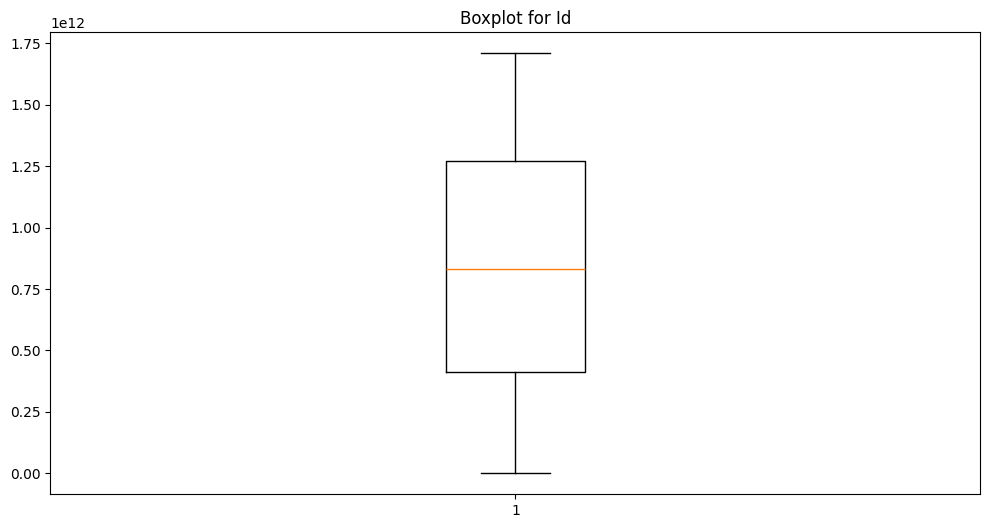

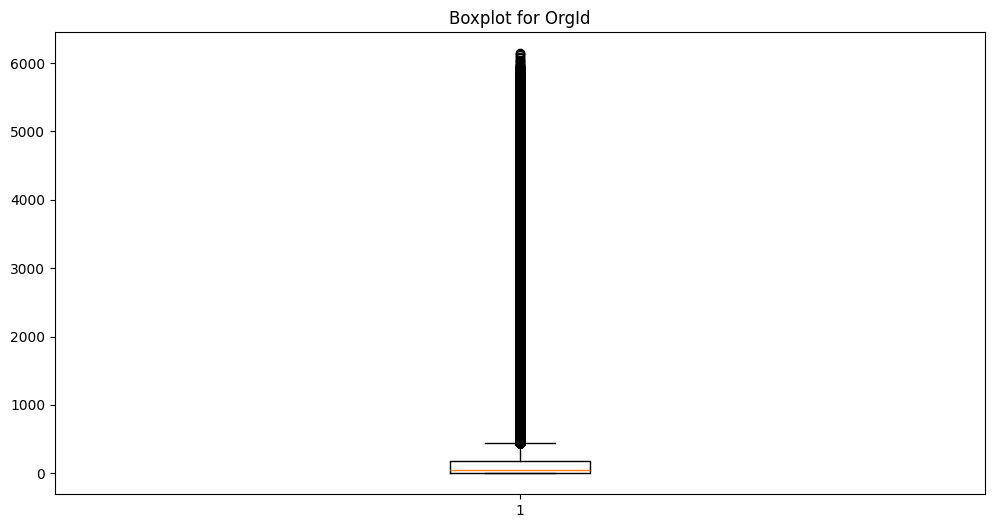

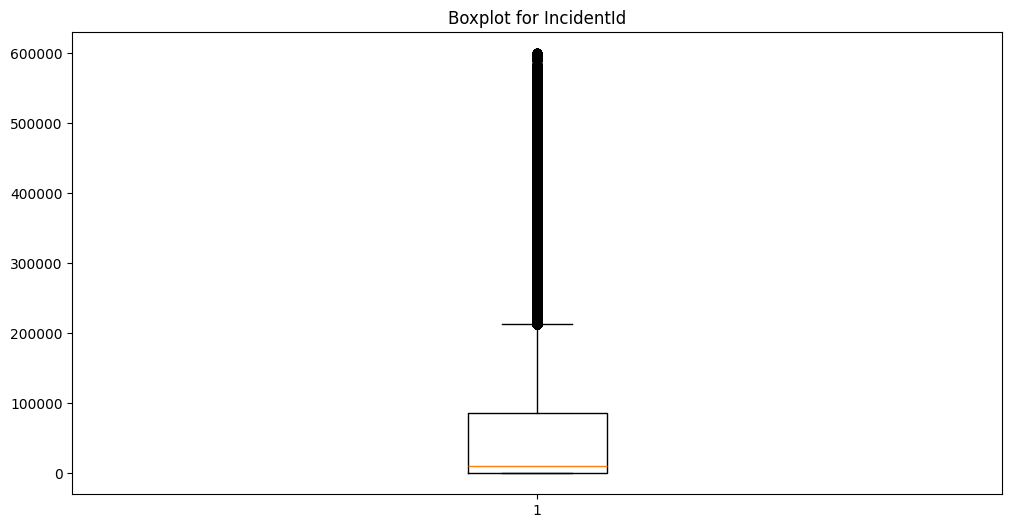

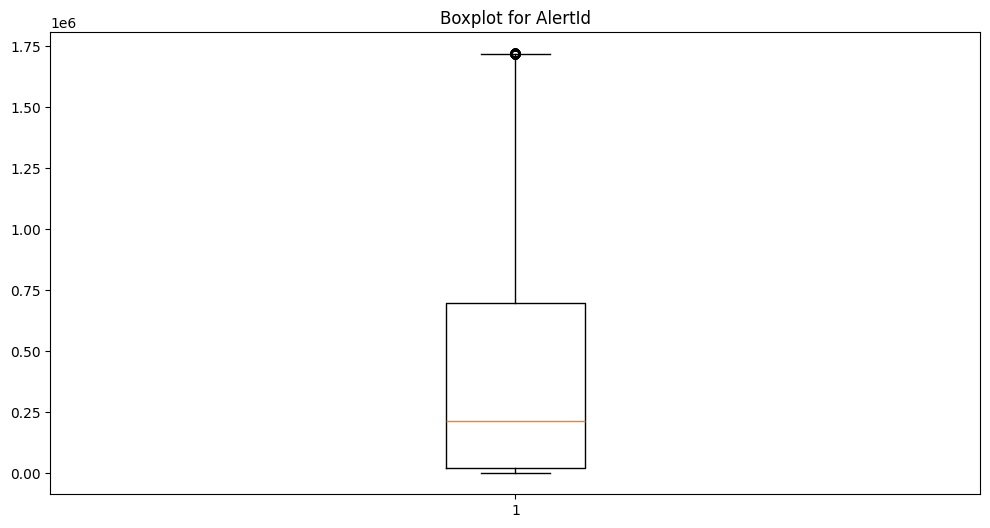

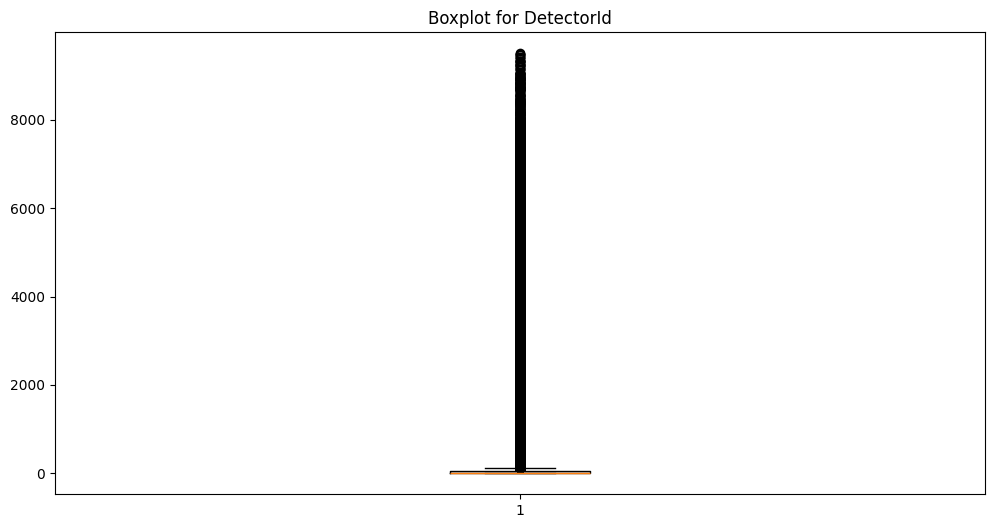

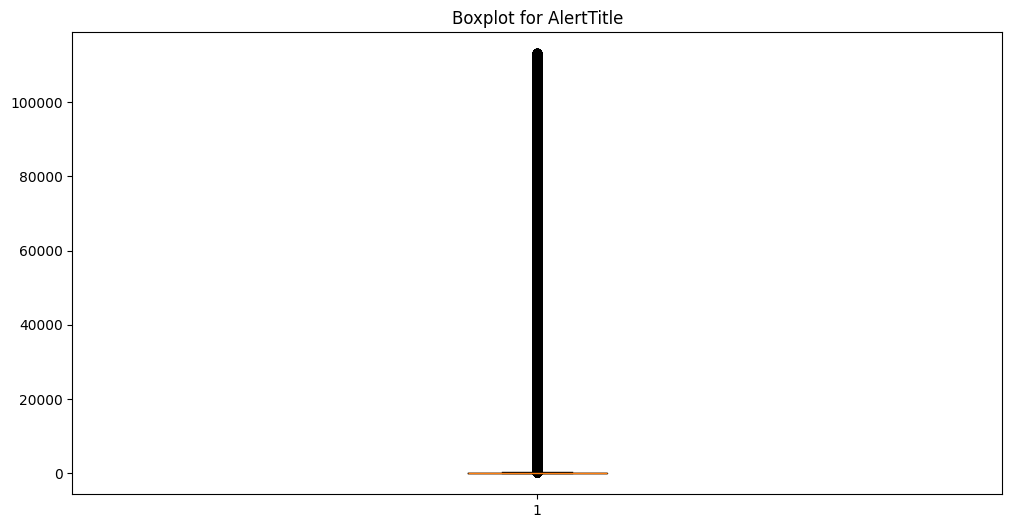

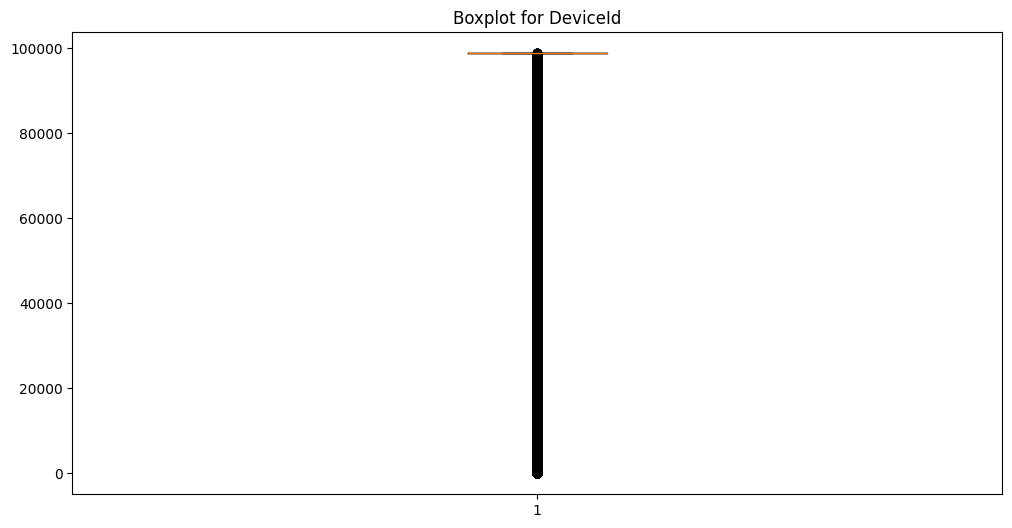

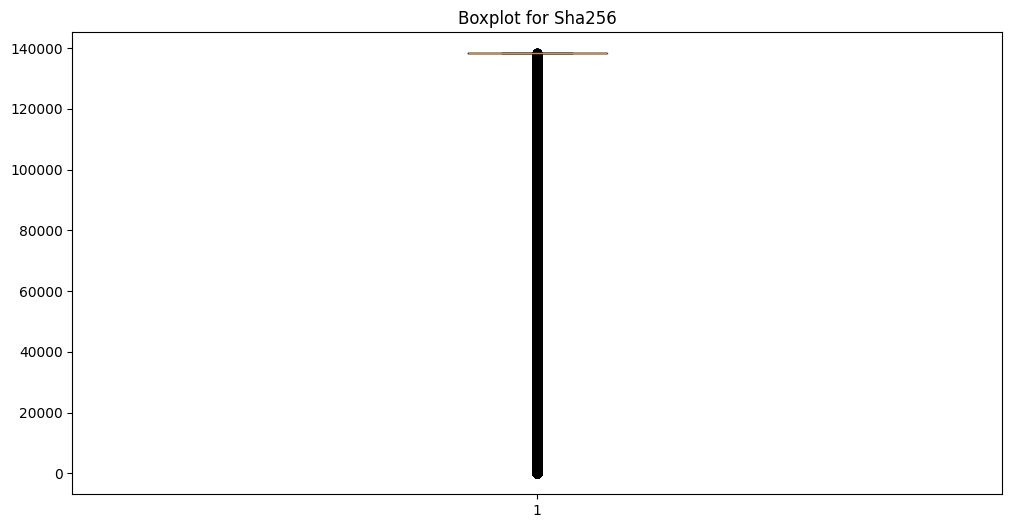

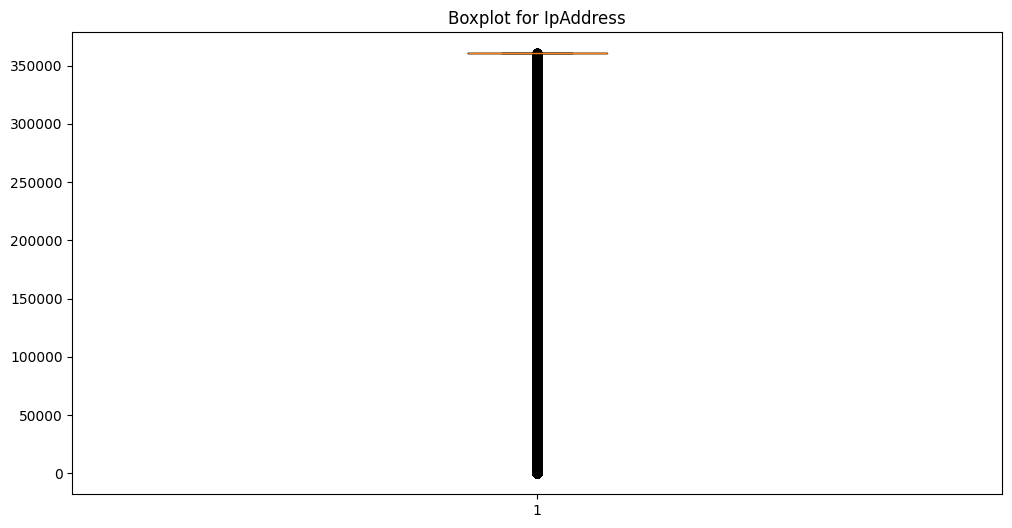

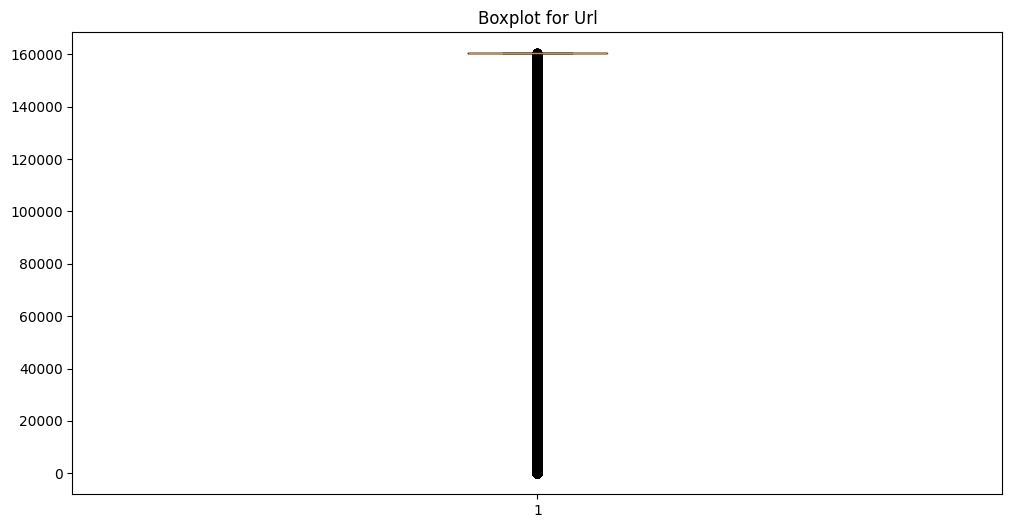

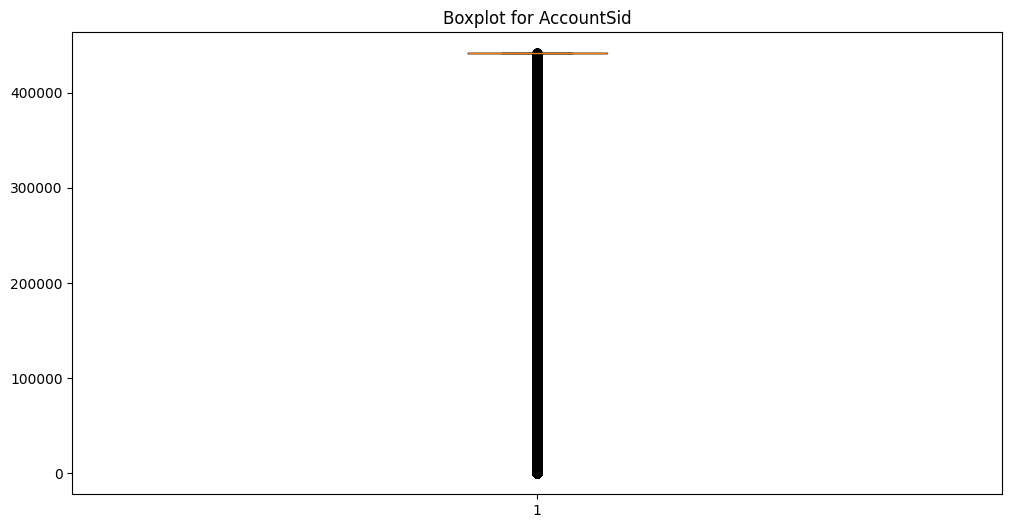

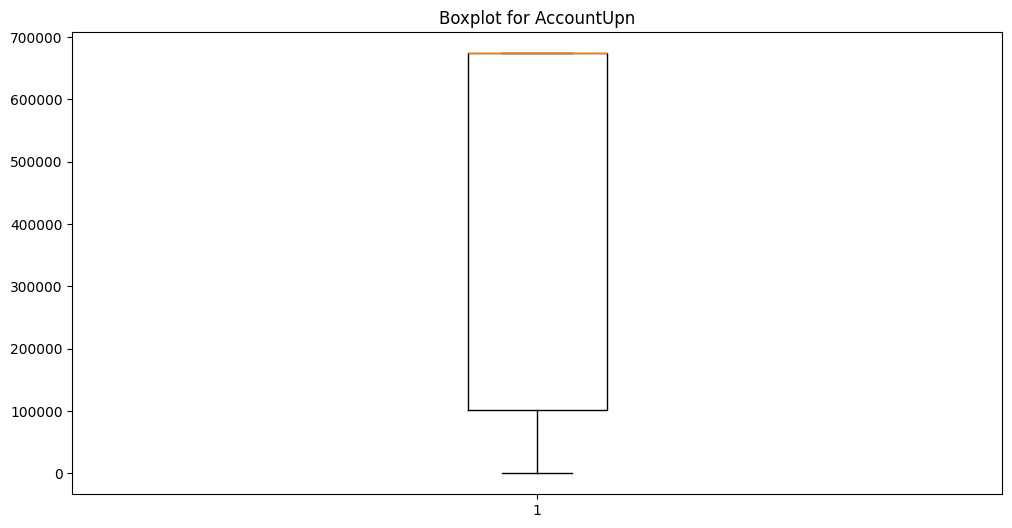

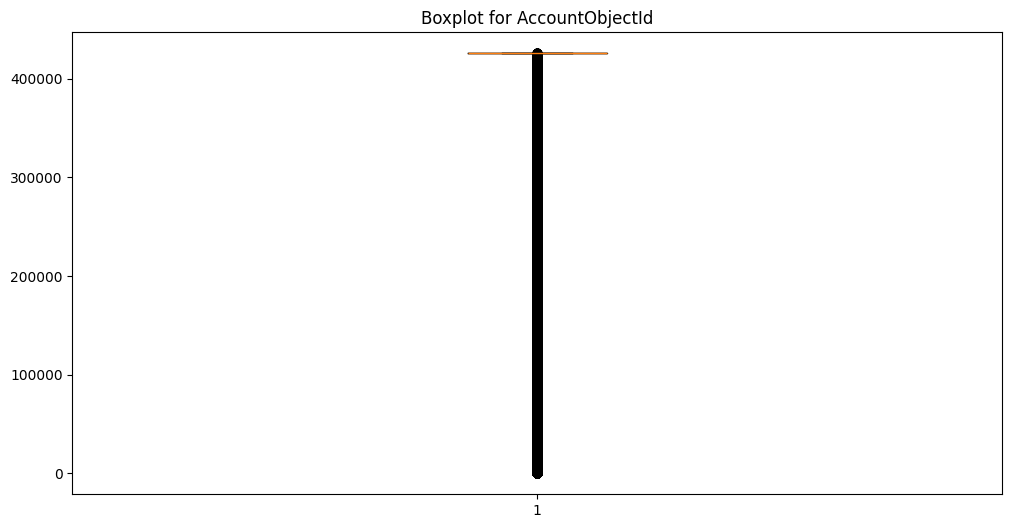

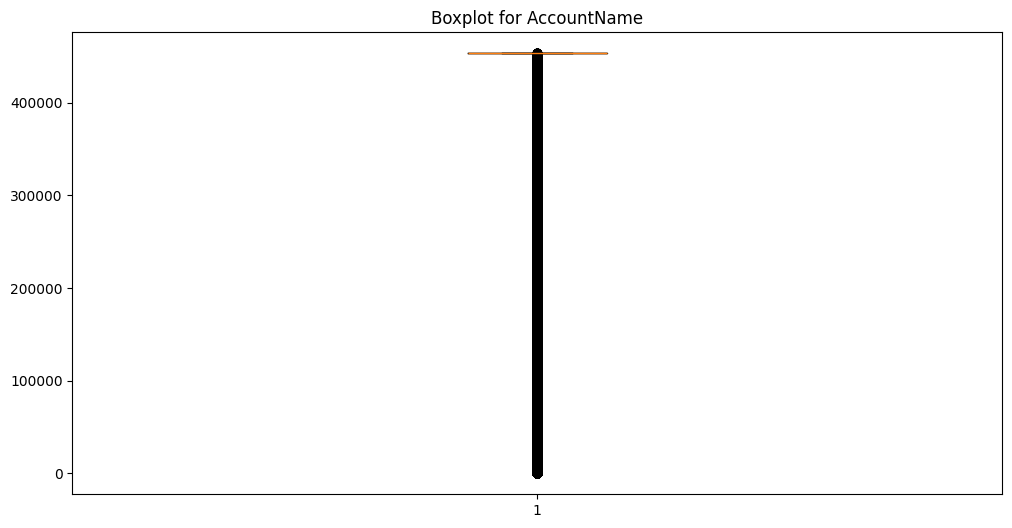

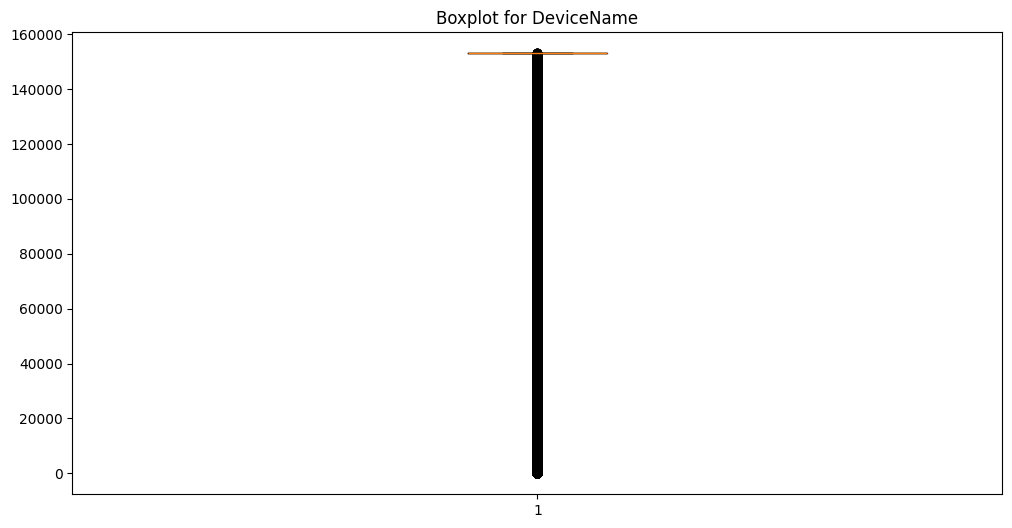

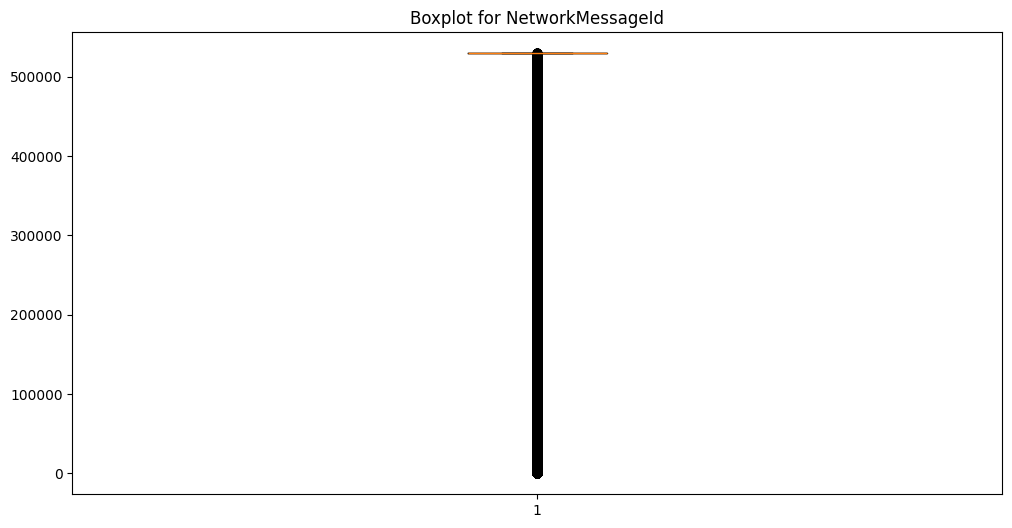

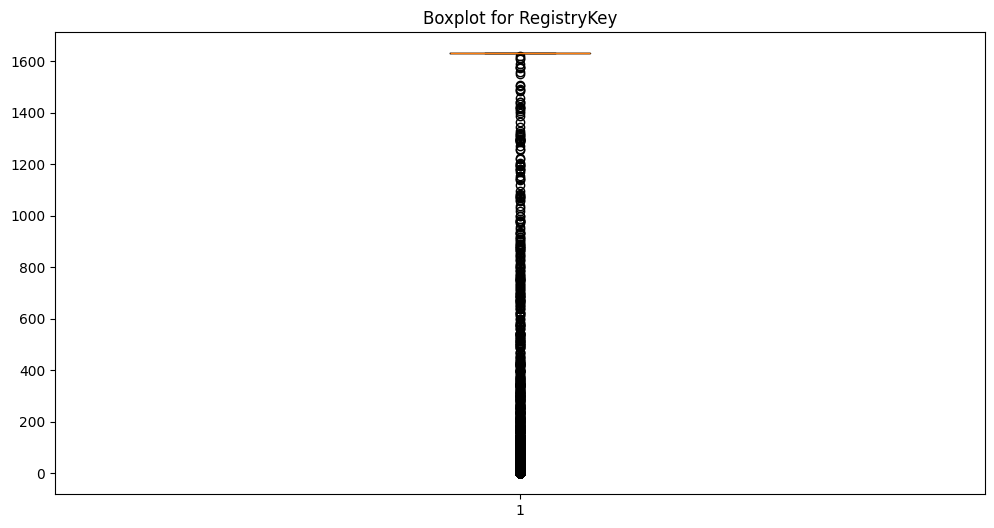

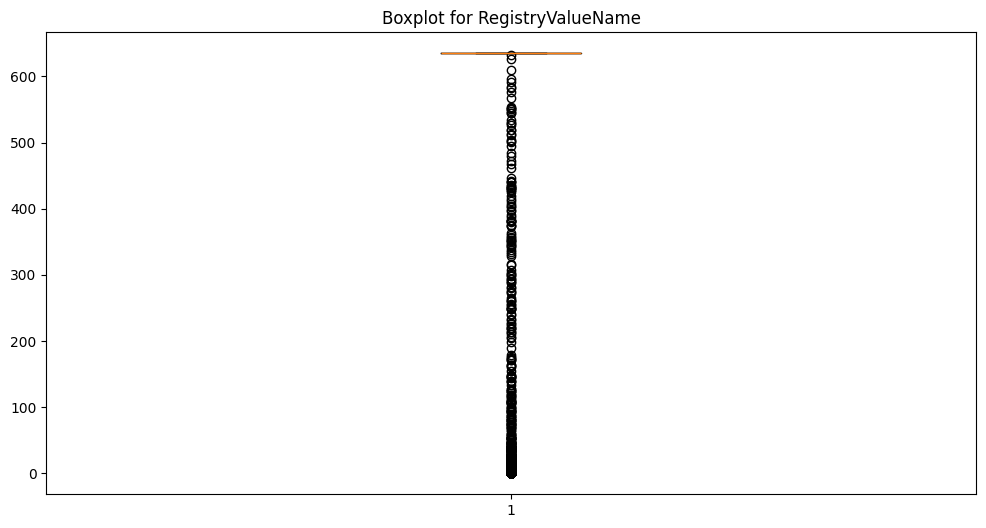

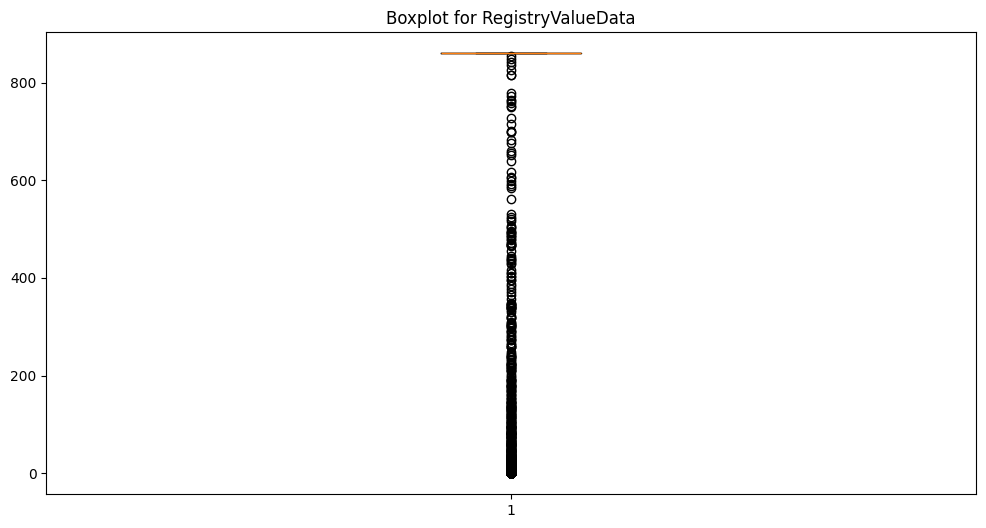

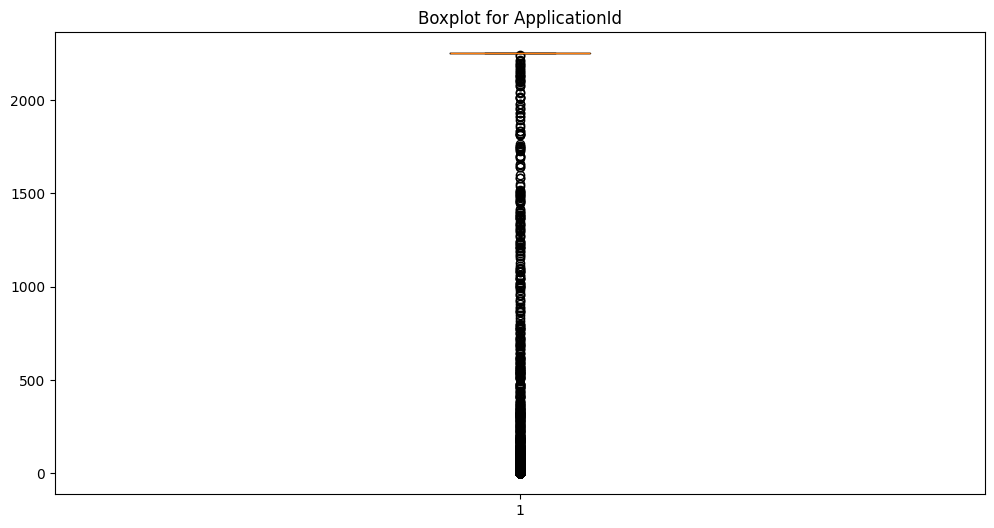

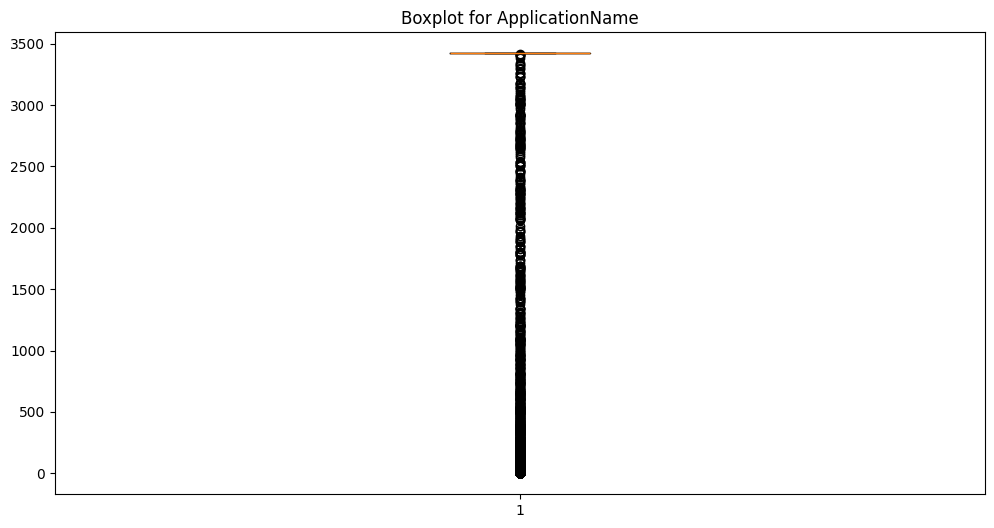

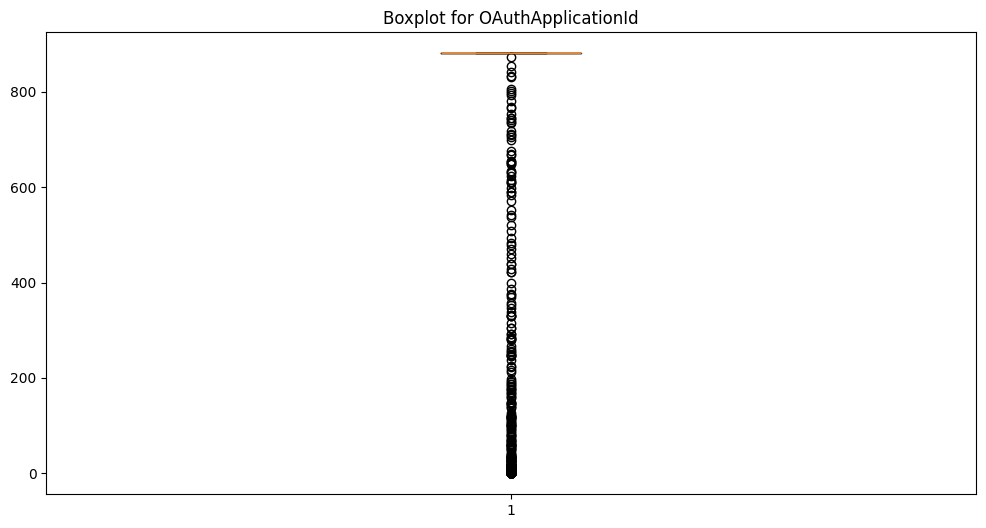

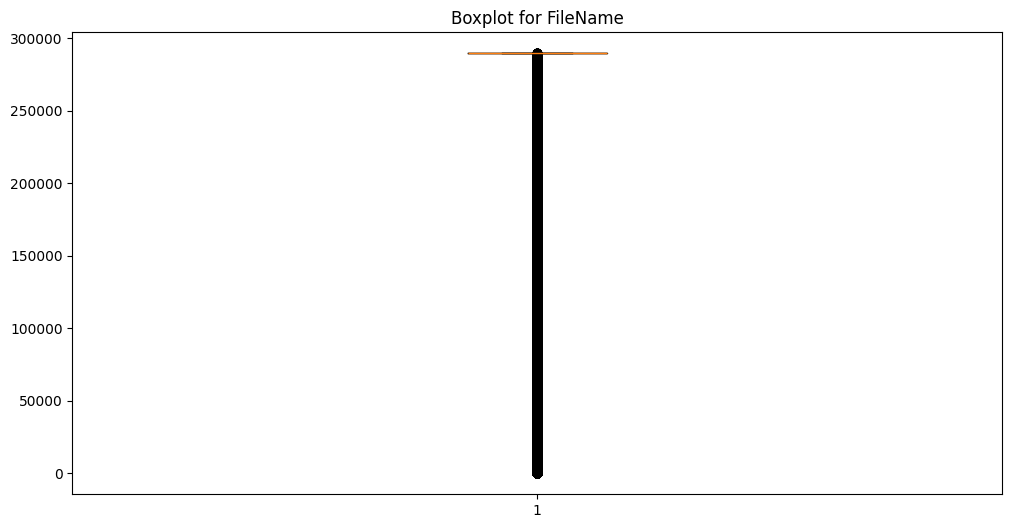

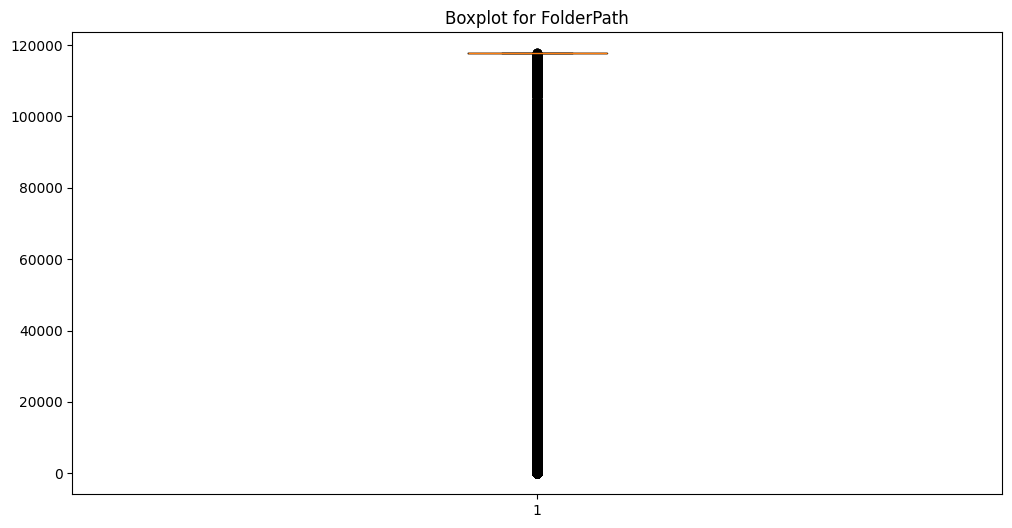

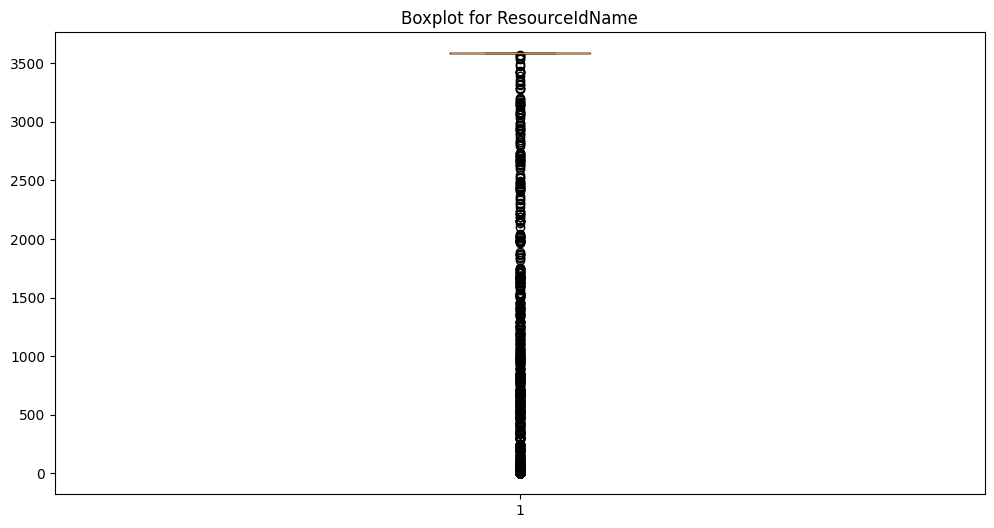

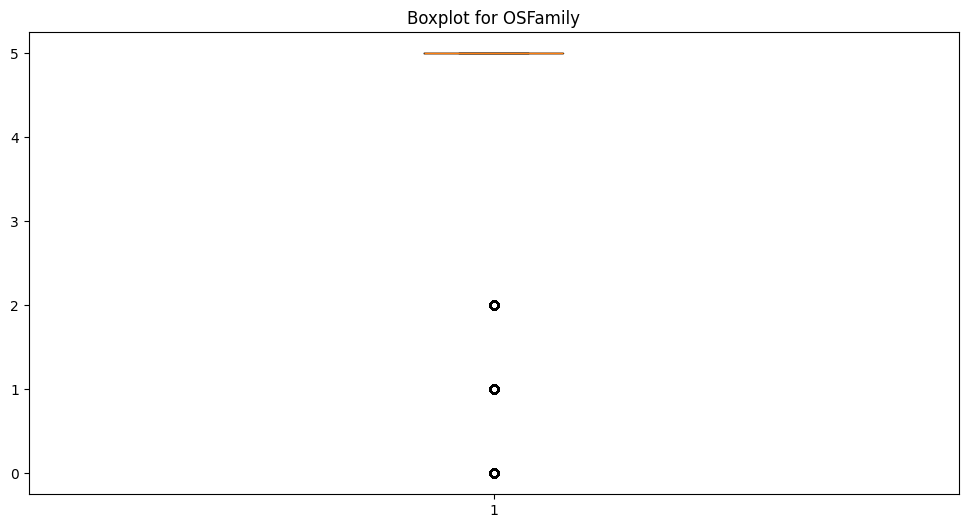

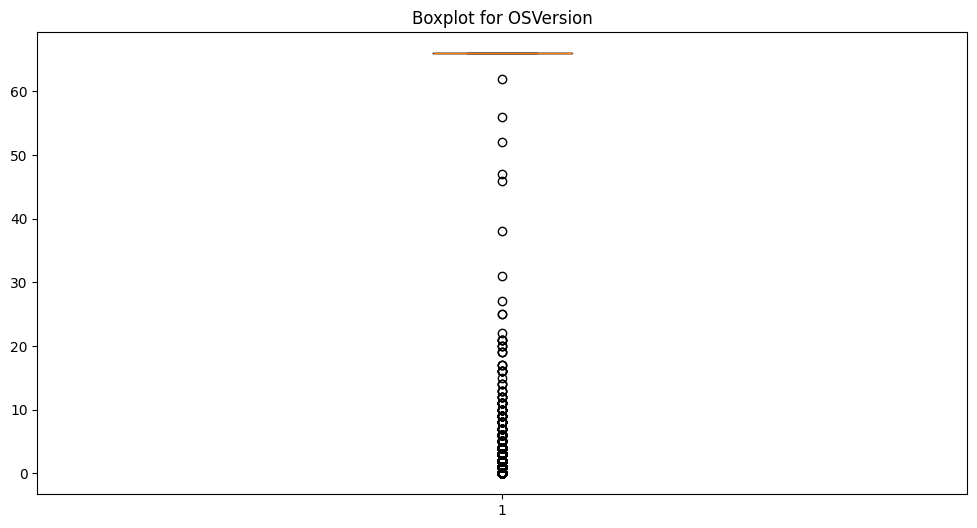

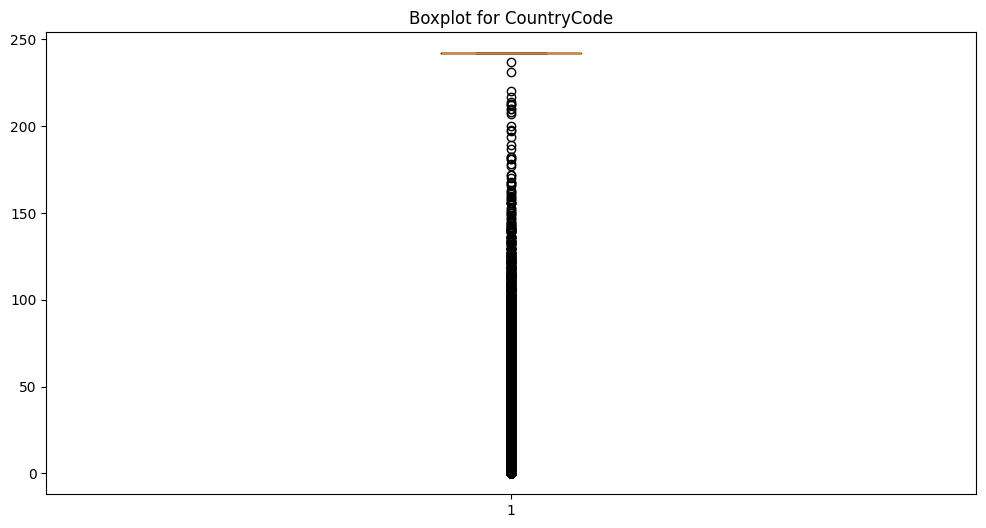

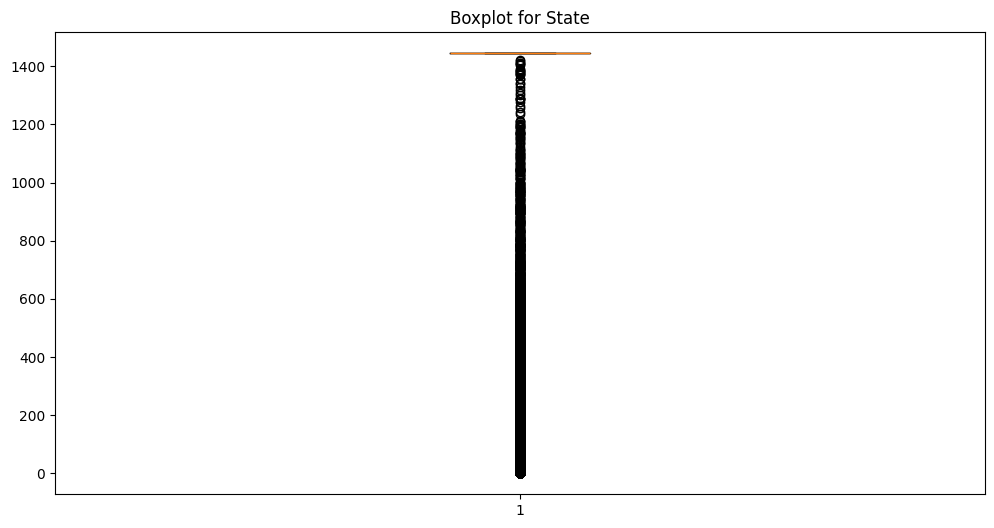

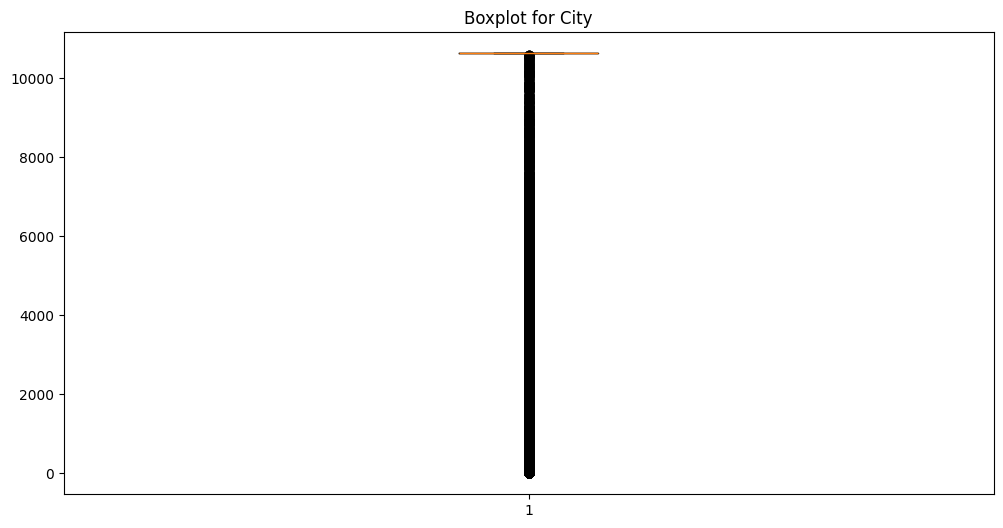

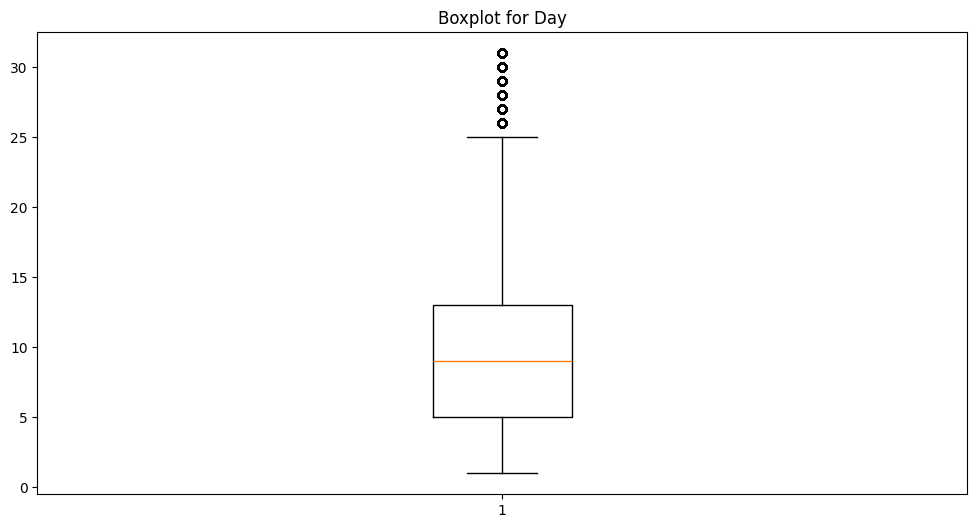

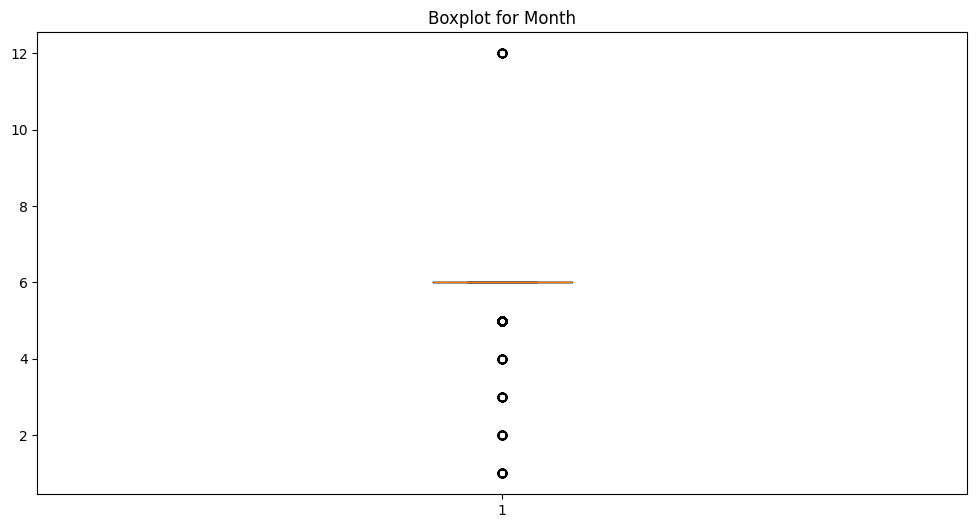

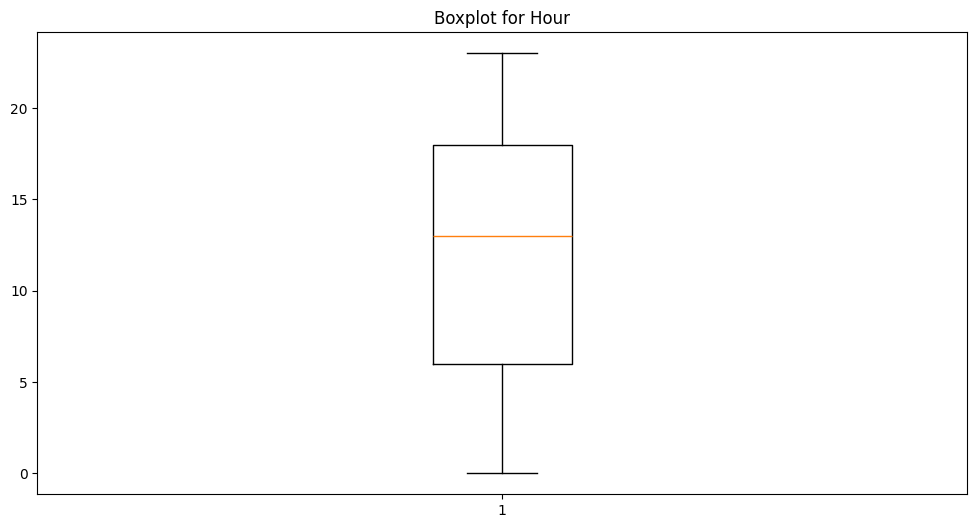

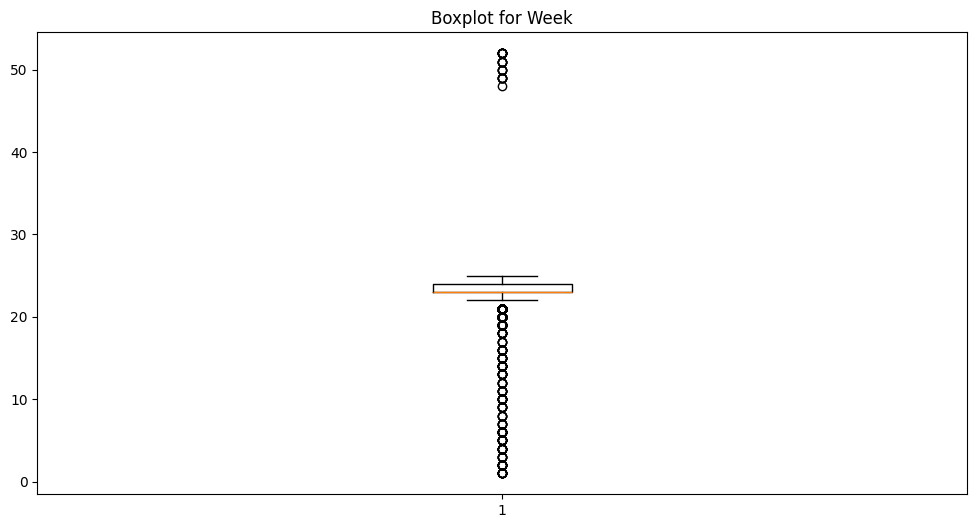

In [16]:
import matplotlib.pyplot as plt

# Loop through each numeric column in the DataFrame
for column in df.select_dtypes(include=['number']).columns:
    # Create the boxplot for the specific column using matplotlib
    plt.figure(figsize=(12, 6))  # Create a new figure for each plot
    plt.boxplot(df[column])
    plt.title(f'Boxplot for {column}')
    plt.show()


In [19]:
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,...,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Day,Month,Hour
38062,34359742386,109,70620,36161,2024-06-12 00:59:09+00:00,75,14894,Exfiltration,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,12,6,0
91681,1073741828770,81,134159,229696,2024-06-07 09:15:00+00:00,65,21683,Exfiltration,BenignPositive,MailMessage,...,117668,3586,5,66,242,1445,10630,7,6,9
3302,77309412873,32,22109,14661,2024-05-30 15:58:48+00:00,763,492,CredentialAccess,BenignPositive,Ip,...,117668,3586,5,66,242,1445,10630,30,5,15
72374,712964574498,692,76345,934982,2024-06-08 04:55:39+00:00,19,15,InitialAccess,BenignPositive,User,...,117668,3586,5,66,242,1445,10630,8,6,4
19935,438086664917,288,111500,360266,2024-06-14 16:06:09+00:00,6,5,InitialAccess,BenignPositive,Mailbox,...,117668,3586,5,66,242,1445,10630,14,6,16


# Heap Map

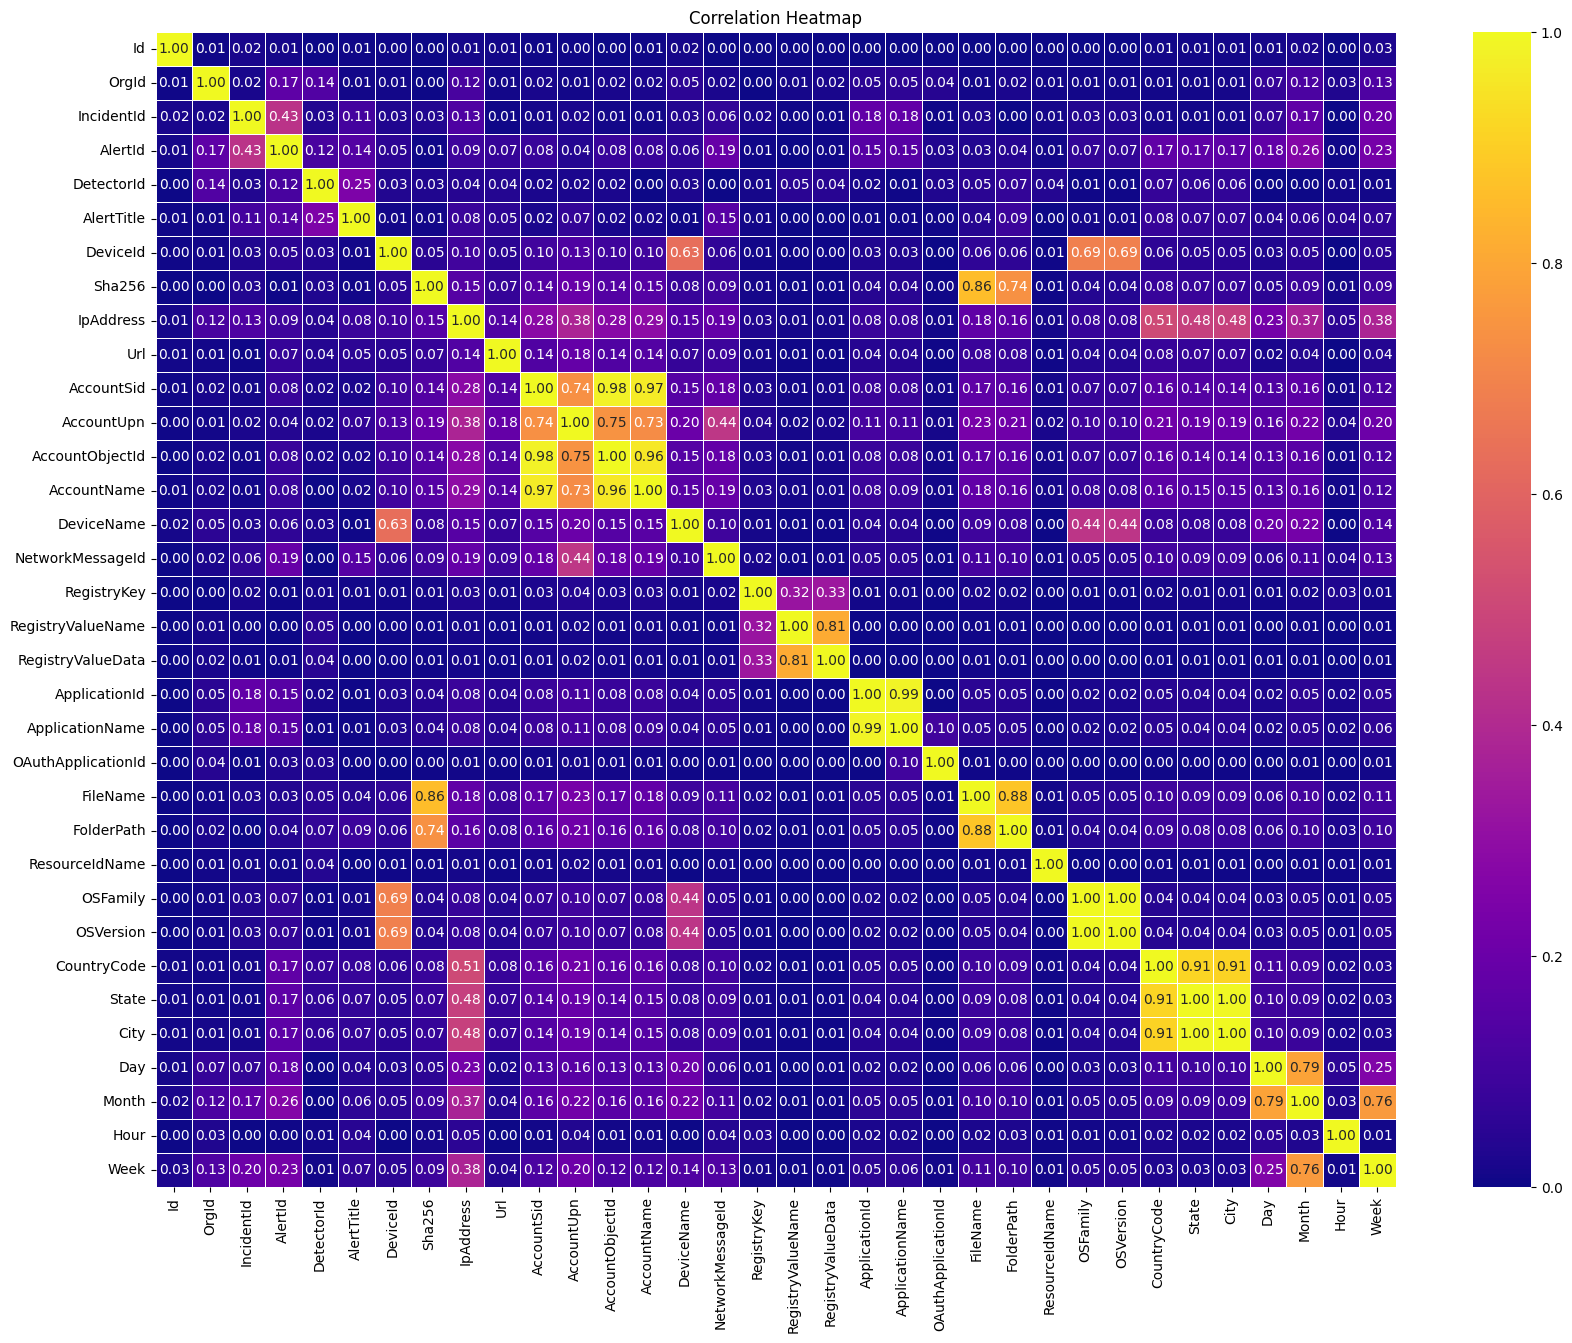

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical columns from the DataFrame
numerical_df = df.select_dtypes(include=['number'])

# Compute the absolute correlation matrix
corr_matrix = numerical_df.corr().abs()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True, cmap='plasma', fmt='.2f', vmin=0, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


In [28]:
import numpy as np

# Assuming df is your DataFrame
numerical_df = df.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Set the correlation threshold
threshold = 0.8

# Find pairs of columns with correlation above the threshold
high_corr_var = np.where(corr_matrix > threshold)

# List to store pairs of columns with high correlation
high_corr_pairs = [(numerical_df.columns[x], numerical_df.columns[y]) 
                    for x, y in zip(*high_corr_var) 
                    if x != y and x < y]

# Create a set of columns to remove (default to adding the second column in each pair)
columns_to_remove = set()
for col1, col2 in high_corr_pairs:
    columns_to_remove.add(col2)  # Default to adding the second column in each pair

# Convert to list
columns_to_remove = list(columns_to_remove)

# Drop the redundant columns from the DataFrame
df_corr = df.drop(columns=columns_to_remove)

# Verify the cleaned DataFrame
print("Columns removed:", columns_to_remove)
print(df_corr.head())


Columns removed: ['OSVersion', 'City', 'RegistryValueData', 'FolderPath', 'FileName', 'AccountObjectId', 'State', 'AccountName', 'ApplicationName']
                  Id  OrgId  IncidentId  AlertId  DetectorId  AlertTitle  \
18179  1090921695549     48      452814   594116           5          72   
72477  1503238557882    286      182082  1394350           9          74   
35692   730144441487     16      110435   290257          24       42020   
29155  1563368099283    247       40087    41875         521         566   
3375   1477468749824     25        1246     7803          30        4437   

                 Category   IncidentGrade        EntityType EvidenceRole  ...  \
18179  SuspiciousActivity  BenignPositive              User     Impacted  ...   
72477           Execution  BenignPositive  CloudApplication     Impacted  ...   
35692        Exfiltration  BenignPositive              User     Impacted  ...   
29155       InitialAccess  BenignPositive       MailMessage      Relate

# LabelEncoder

In [29]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# List of categorical columns
categorical_cols = df_corr.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df_corr[col] = label_encoder.fit_transform(df_corr[col])

# Verify the changes
print(df_corr[categorical_cols].head())


       Category  IncidentGrade  EntityType  EvidenceRole
18179        16              0          27             0
72477         6              0           5             0
35692         7              0          27             0
29155        10              0          16             1
3375          7              0          16             0


In [33]:
df_corr

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Hour,Week
18179,1090921695549,48,452814,594116,5,72,16,0,27,0,...,635,2251,881,3586,5,242,15,6,4,24
72477,1503238557882,286,182082,1394350,9,74,6,0,5,0,...,635,3,881,3586,5,242,10,6,18,24
35692,730144441487,16,110435,290257,24,42020,7,0,27,0,...,635,2251,881,3586,5,242,7,6,13,23
29155,1563368099283,247,40087,41875,521,566,10,0,16,1,...,635,2251,881,3586,5,242,3,6,13,23
3375,1477468749824,25,1246,7803,30,4437,7,0,16,0,...,635,2251,881,3586,5,242,7,6,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386475,489626275841,353,164028,827269,0,0,10,1,7,1,...,635,2251,881,3586,5,242,12,6,14,24
2318253,738734378854,195,16656,1179035,14,12,2,1,6,1,...,635,2251,881,3586,5,242,6,6,17,23
2379177,472446407144,9,379,633935,31,229,12,1,14,0,...,635,2251,881,3586,0,242,13,6,0,24
2365397,584115555313,210,2552,6529,91,68,2,1,27,1,...,635,2251,881,3586,5,242,6,6,18,23


# Save to csv

In [34]:
df_corr.to_csv('traindata5thproject', index=False)

# Splitting data

In [27]:
# Splitting data
X= df_corr.drop('IncidentGrade',axis=1)
y= df_corr['IncidentGrade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
X

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,EntityType,EvidenceRole,DeviceId,...,RegistryKey,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Hour
38062,34359742386,109,70620,36161,75,14894,7,27,0,98799,...,1631,635,2251,881,3586,5,242,12,6,0
91681,1073741828770,81,134159,229696,65,21683,7,16,0,98799,...,1631,635,2251,881,3586,5,242,7,6,9
3302,77309412873,32,22109,14661,763,492,2,13,1,98799,...,1631,635,2251,881,3586,5,242,30,5,15
72374,712964574498,692,76345,934982,19,15,10,27,0,98799,...,1631,635,2251,881,3586,5,242,8,6,4
19935,438086664917,288,111500,360266,6,5,10,17,0,98799,...,1631,635,2251,881,3586,5,242,14,6,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364229,1666447311459,93,9,0,27,18,5,27,0,98799,...,1631,635,2251,881,3586,5,242,12,6,1
2345930,687194768214,61,889,187272,5,31,16,27,0,98799,...,1631,635,2251,881,3586,5,242,8,6,4
2370150,1288490189675,18,147864,1070161,9,32,6,5,0,98799,...,1631,635,4,881,3586,5,242,6,6,13
2340650,1082331760276,1517,40418,993861,0,0,10,7,1,98799,...,1631,635,2251,881,3586,5,242,12,6,16


In [65]:
df_corr.columns

(1499197, 29)

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [189]:
df_corr['Hour'].isnull().sum()

0

# LogisticRegression

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
clf = LogisticRegression(max_iter=1000)

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
classification_predictions = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, classification_predictions)
precision = precision_score(y_test, classification_predictions, average='macro')
recall = recall_score(y_test, classification_predictions, average='macro')
f1 = f1_score(y_test, classification_predictions, average='macro')
conf_matrix = confusion_matrix(y_test, classification_predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.43442836179295624
Precision (Macro): 0.44101209721749873
Recall (Macro): 0.43500792416463946
F1 Score (Macro): 0.42151539353104545
Confusion Matrix:
 [[61907 18045 19452]
 [55437 23617 21263]
 [38241 17143 44735]]


# DecisionTreeClassifier

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree Classifier model
classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
classifier.fit(X_train, y_train)

# Make predictions
classification_predictions = classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, classification_predictions)
precision = precision_score(y_test, classification_predictions, average='macro')
recall = recall_score(y_test, classification_predictions, average='macro')
f1 = f1_score(y_test, classification_predictions, average='macro')
conf_matrix = confusion_matrix(y_test, classification_predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9754769210245464
Precision (Macro): 0.9754810815482425
Recall (Macro): 0.9754720619580964
F1 Score (Macro): 0.9754756781292628
Confusion Matrix:
 [[96753  1568  1083]
 [ 1351 97819  1147]
 [ 1054  1150 97915]]


# RandomForestClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_clf.fit(X_train, y_train)

# Make predictions
classification_predictions = rf_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, classification_predictions)
precision = precision_score(y_test, classification_predictions, average='macro')
recall = recall_score(y_test, classification_predictions, average='macro')
f1 = f1_score(y_test, classification_predictions, average='macro')
conf_matrix = confusion_matrix(y_test, classification_predictions)


# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_matrix)


#  Gradient Boosting Classifier

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier model
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Fit the model
gb_clf.fit(X_train, y_train)

# Make predictions
classification_predictions = gb_clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, classification_predictions)
precision = precision_score(y_test, classification_predictions, average='macro')
recall = recall_score(y_test, classification_predictions, average='macro')
f1 = f1_score(y_test, classification_predictions, average='macro')
conf_matrix = confusion_matrix(y_test, classification_predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision (Macro):", precision)
print("Recall (Macro):", recall)
print("F1 Score (Macro):", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.7984625133404483
Precision (Macro): 0.8102653814763755
Recall (Macro): 0.7986210069579031
F1 Score (Macro): 0.7995845336424333
Confusion Matrix:
 [[85670 10482  3252]
 [16778 78938  4601]
 [17399  7917 74803]]



 
 
 
 
 
 # TEST DATA

In [57]:
file_path = r"GUIDE_Test[1].csv"

# Target row count per class
target_rows_per_class = 500_000

# Initialize dictionaries to store sampled data for each class
samples_per_class = {'BenignPositive': [], 'TruePositive': [], 'FalsePositive': []}

# Define chunk size to avoid memory overload
chunk_size = 100_000

# Read the CSV file in chunks
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    # For each class, sample rows if the target has not been reached
    for class_value in samples_per_class.keys():
        # Filter rows of the current class
        class_rows = chunk[chunk['IncidentGrade'] == class_value]
        
        # Calculate how many more rows are needed for this class
        remaining_rows = target_rows_per_class - sum(len(df) for df in samples_per_class[class_value])
        
        # If more rows are needed, sample accordingly
        if remaining_rows > 0:
            samples_per_class[class_value].append(class_rows.sample(n=min(remaining_rows, len(class_rows))))

    # Stop reading further chunks if we’ve collected enough rows for each class
    if all(sum(len(df) for df in samples) >= target_rows_per_class for samples in samples_per_class.values()):
        break

# Concatenate samples to create the final balanced dataset
df_test = pd.concat([pd.concat(samples) for samples in samples_per_class.values()])


C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\2592158707.py:13: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\2592158707.py:13: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\2592158707.py:13: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\2592158707.py:13: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv(file_path, chunksize=chunk_size):
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\2592158707.py:13: DtypeW

# Null check

In [58]:

df_test
df_test.isnull().sum()



Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques        810284
IncidentGrade               0
ActionGrouped         1499224
ActionGranular        1499224
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        1485284
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          1489959
FileName                    0
FolderPath

# Remove Duplicate

In [59]:

df_test.duplicated().sum()
df_test.drop_duplicates(inplace=True)
df_test.duplicated().sum()




0

# Feature engineering - Converting Timestamp column into Day, Month and Hour

In [60]:
# Convert 'Timestamp' column to datetime
df_test['Timestamp'] = pd.to_datetime(df_test['Timestamp'])

# Extract day, month, hour, and week from the 'Timestamp' column
df_test['Day'] = df_test['Timestamp'].dt.day
df_test['Month'] = df_test['Timestamp'].dt.month
df_test['Hour'] = df_test['Timestamp'].dt.hour

# Use isocalendar() to extract the week number
df_test['Week'] = df_test['Timestamp'].dt.isocalendar().week

# Drop the 'Timestamp' column as it's no longer needed
df_test.drop(columns=['Timestamp'], inplace=True)

In [61]:
df_test.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques        810279
IncidentGrade               0
ActionGrouped         1499209
ActionGranular        1499209
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        1485269
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          1489944
FileName                    0
FolderPath                  0
ResourceId

In [64]:
df_test.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'MitreTechniques', 'IncidentGrade', 'ActionGrouped',
       'ActionGranular', 'EntityType', 'EvidenceRole', 'DeviceId', 'Sha256',
       'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
       'AccountName', 'DeviceName', 'NetworkMessageId', 'EmailClusterId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId',
       'ThreatFamily', 'FileName', 'FolderPath', 'ResourceIdName',
       'ResourceType', 'Roles', 'OSFamily', 'OSVersion', 'AntispamDirection',
       'SuspicionLevel', 'LastVerdict', 'CountryCode', 'State', 'City',
       'Usage', 'Day', 'Month', 'Hour', 'Week'],
      dtype='object')

# Remove Columns

In [70]:
df_test = df_test[['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'DeviceName',
       'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 'ApplicationId',
       'OAuthApplicationId', 'ResourceIdName', 'OSFamily', 'CountryCode',
       'Day', 'Month', 'Hour', 'Week']]


In [78]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1499985 entries, 67100 to 2283332
Data columns (total 29 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   Id                  1499985 non-null  int64 
 1   OrgId               1499985 non-null  int64 
 2   IncidentId          1499985 non-null  int64 
 3   AlertId             1499985 non-null  int64 
 4   DetectorId          1499985 non-null  int64 
 5   AlertTitle          1499985 non-null  int64 
 6   Category            1499985 non-null  object
 7   IncidentGrade       1499985 non-null  object
 8   EntityType          1499985 non-null  object
 9   EvidenceRole        1499985 non-null  object
 10  DeviceId            1499985 non-null  int64 
 11  Sha256              1499985 non-null  int64 
 12  IpAddress           1499985 non-null  int64 
 13  Url                 1499985 non-null  int64 
 14  AccountSid          1499985 non-null  int64 
 15  AccountUpn          1499985 non-n

In [80]:
df_test.head()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Hour,Week
67100,1005022347995,120,121132,112263,84,14893,Exfiltration,BenignPositive,MailMessage,Impacted,...,635,2251,881,3586,5,242,5,6,21,23
32165,1254130455382,152,3989,2642,232,211,CredentialAccess,BenignPositive,Ip,Related,...,635,2251,881,3586,5,242,9,6,23,23
54241,1683627184909,152,83762,946238,0,0,InitialAccess,BenignPositive,Ip,Related,...,635,2251,881,3586,5,4,11,6,10,24
41718,317827581215,44,1567,15495,50,36,Exfiltration,BenignPositive,MailMessage,Impacted,...,635,2251,881,3586,5,242,15,6,8,24
87781,910533067991,215,35612,68280,1,1,InitialAccess,BenignPositive,MailCluster,Related,...,635,2251,881,3586,5,242,15,6,21,24


In [81]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# List of categorical columns
categorical_cols = df_test.select_dtypes(include=['object']).columns

# Apply Label Encoding to each categorical column
for col in categorical_cols:
    df_test[col] = label_encoder.fit_transform(df_test[col])

# Verify the changes
print(df_test[categorical_cols].head())


C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1052230533.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = label_encoder.fit_transform(df_test[col])
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1052230533.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = label_encoder.fit_transform(df_test[col])
C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1052230533.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

       Category  IncidentGrade  EntityType  EvidenceRole
67100         7              0          14             0
32165         2              0          11             1
54241        10              0          11             1
41718         7              0          14             0
87781        10              0          13             1


C:\Users\dhars\AppData\Local\Temp\ipykernel_19960\1052230533.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = label_encoder.fit_transform(df_test[col])


In [82]:
df_test

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,...,RegistryValueName,ApplicationId,OAuthApplicationId,ResourceIdName,OSFamily,CountryCode,Day,Month,Hour,Week
67100,1005022347995,120,121132,112263,84,14893,7,0,14,0,...,635,2251,881,3586,5,242,5,6,21,23
32165,1254130455382,152,3989,2642,232,211,2,0,11,1,...,635,2251,881,3586,5,242,9,6,23,23
54241,1683627184909,152,83762,946238,0,0,10,0,11,1,...,635,2251,881,3586,5,4,11,6,10,24
41718,317827581215,44,1567,15495,50,36,7,0,14,0,...,635,2251,881,3586,5,242,15,6,8,24
87781,910533067991,215,35612,68280,1,1,10,0,13,1,...,635,2251,881,3586,5,242,15,6,21,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200286,231928234560,93,10,0,27,18,5,1,25,0,...,635,2251,881,3586,5,242,11,6,22,24
2212042,395136994352,73,576373,1612333,80,102778,7,1,25,0,...,635,2251,881,3586,5,242,4,6,8,23
2218285,68719479735,124,26628,339587,9,64,6,1,4,0,...,635,2,881,3586,5,242,6,6,5,23
2233619,146028892595,105,30381,119594,6,5,10,1,25,0,...,635,2251,881,3586,5,242,12,6,0,24


# Save to csv

In [83]:


df_test.to_csv('testdata5thproject', index=False)